Let's start by importing all the libraries we will use.

In [1]:
import numpy as np
from sklearn import manifold
from matplotlib import pyplot as plt
%matplotlib inline
import lap
import hungarian

Now we create 2,025 3d points. 

In [2]:
side = 45
totalDataPoints = side * side
data3d = np.random.uniform(low=0.0, high=1.0, size=(totalDataPoints, 3))

And use sklearn's t-SNE implementation to create a 2d embedding.

In [3]:
tsne = manifold.TSNE(n_components=2, learning_rate=50)
%time data2d = tsne.fit_transform(data3d)

CPU times: user 18 s, sys: 1.78 s, total: 19.8 s
Wall time: 19.7 s


The output of t-SNE is not normalized, so we do that now. This isn't strictly necessary, but makes it easier to visualize the results of the assignment solution.

In [4]:
data2d -= data2d.min(axis=0)
data2d /= data2d.max(axis=0)

Let's plot the data using the 3d points as colors and 2d points for position.

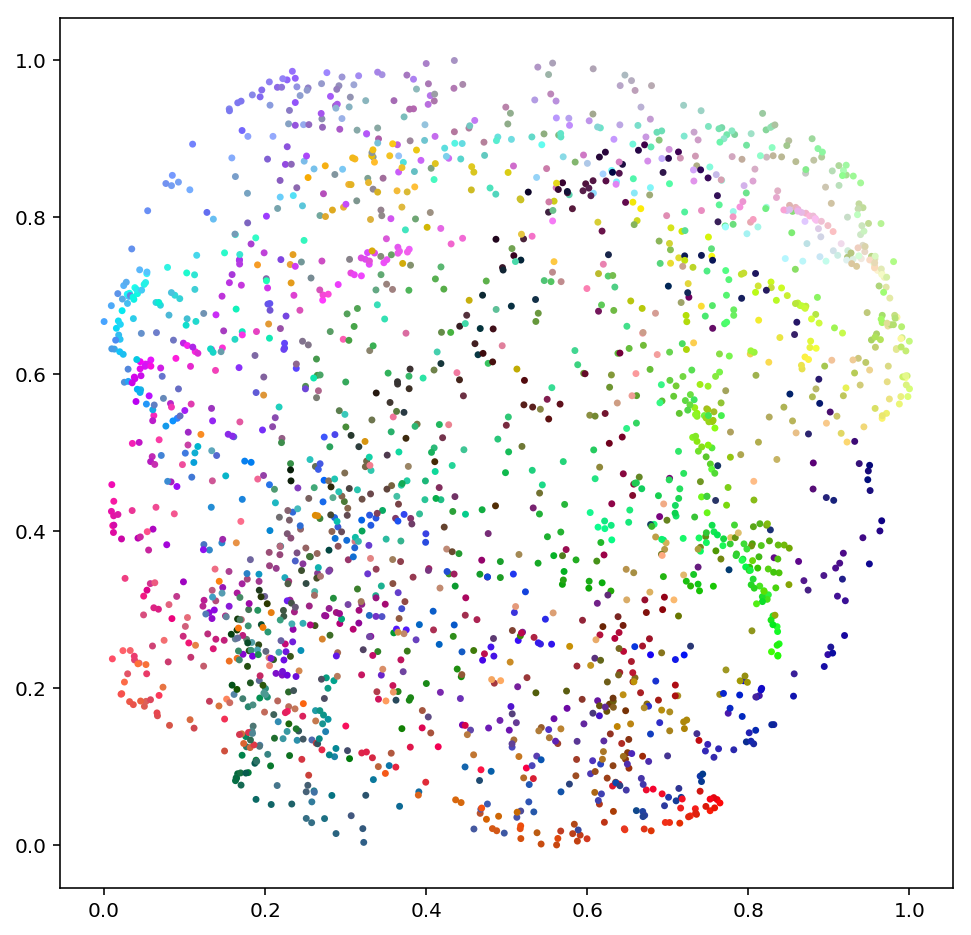

In [5]:
plt.figure(figsize=(8, 8))
plt.scatter(data2d[:,0], data2d[:,1], c=data3d, edgecolors='none', marker='o', s=12)  
plt.show()

Now let's make a list of grid points that we want to map our data onto.

In [6]:
xv, yv = np.meshgrid(np.linspace(0, 1, side), np.linspace(0, 1, side))
grid = np.dstack((xv, yv)).reshape(-1, 2)

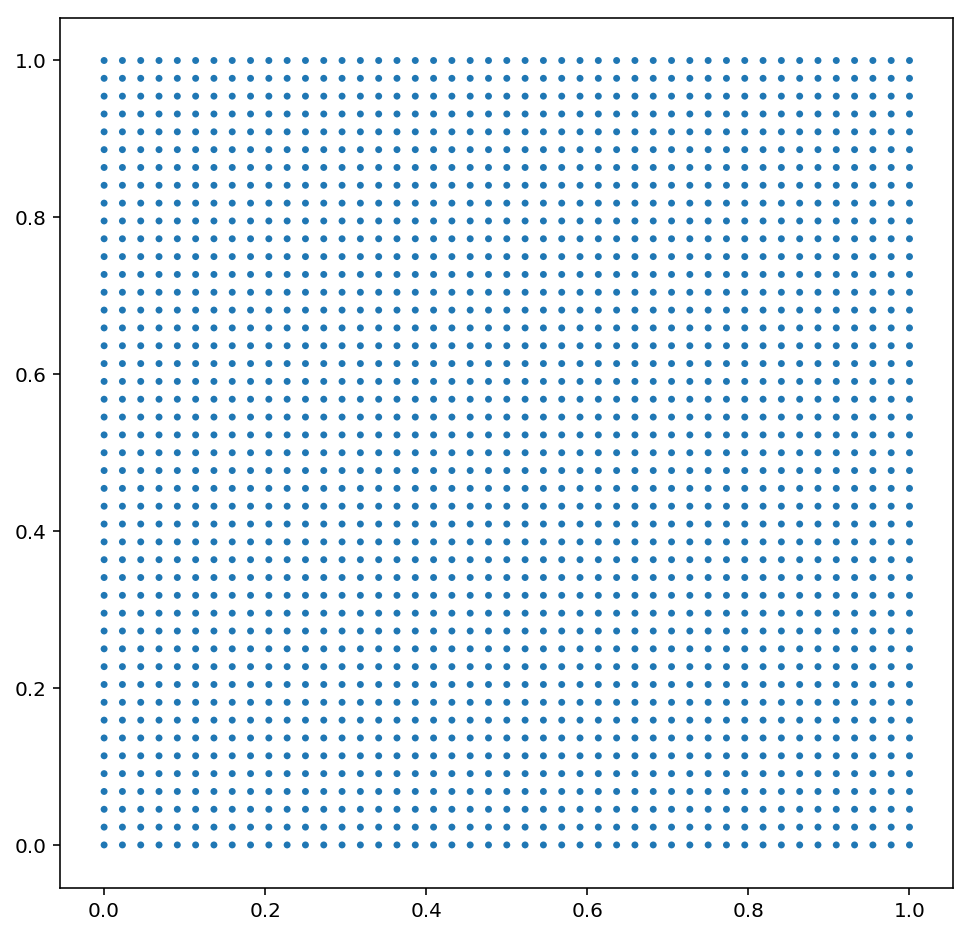

In [7]:
plt.figure(figsize=(8,8))
plt.scatter(grid[:,0], grid[:,1], edgecolors='none', marker='o', s=12)
plt.show()

Now we have two sets of 2d points.

In [8]:
print grid.shape
print data2d.shape

(2025, 2)
(2025, 2)


We evaluate a cost function that defines $n^2$ distances between the points. I like the results from the squared euclidean distance best.

CPU times: user 14.7 ms, sys: 3.48 ms, total: 18.2 ms
Wall time: 17.4 ms


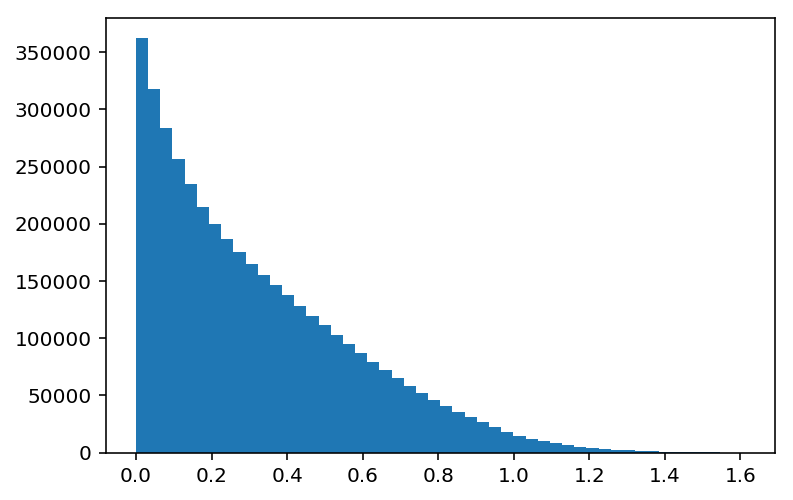

In [9]:
from scipy.spatial.distance import cdist
%time cost = cdist(grid, data2d, 'sqeuclidean')
plt.hist(cost.flatten(), bins=50)
plt.show()

After computing our cost matrix, it's super important to make the values of the cost matrix bigger. If any of the differences between two values in the cost matrix is too small, both the Hungarian algorithm and the JV algorithm can fail. Using the squared euclidean distance makes the JV algorithm more likely to fail than if you switch to the euclidean distance.

I've noticed if you normalize to a maximum value that is too large, this can also cause the Hungarian implementation to crash.

In [10]:
cost = cost * (10000000. / cost.max())

Let's run the Hungarian algorithm on the cost matrix, take the results in `col_assign` to rearrange our `grid` list, and plot arrows from `data2d` to `grid_hu`. For 2k points it takes about 5 seconds on my laptop, and this implementation is $O(n^3)$. We make a copy of the cost because the `lap()` method modifies the cost matrix. If we weren't going to re-use the cost matrix, we wouldn't need to make a copy of the cost. One other optimization is to use an integer cost matrix: `hungarian.lap(cost.astype(np.int)`, which runs in 4s instead of 5s on my machine. (But this might also introduce small errors depending on the distribution of your cost matrix.)

Help on module hungarian:

NAME
    hungarian

FILE
    /Users/kyle/anaconda/lib/python2.7/site-packages/hungarian.so

FUNCTIONS
    lap(...)
        Solves the linear assignment problem using the Hungarian
        algorithm.
        
        hungarian() takes a single argument - a square cost matrix - and returns a
        tuple of the form
        (row_assigns,col_assigns).


CPU times: user 4.3 s, sys: 12.5 ms, total: 4.31 s
Wall time: 4.31 s


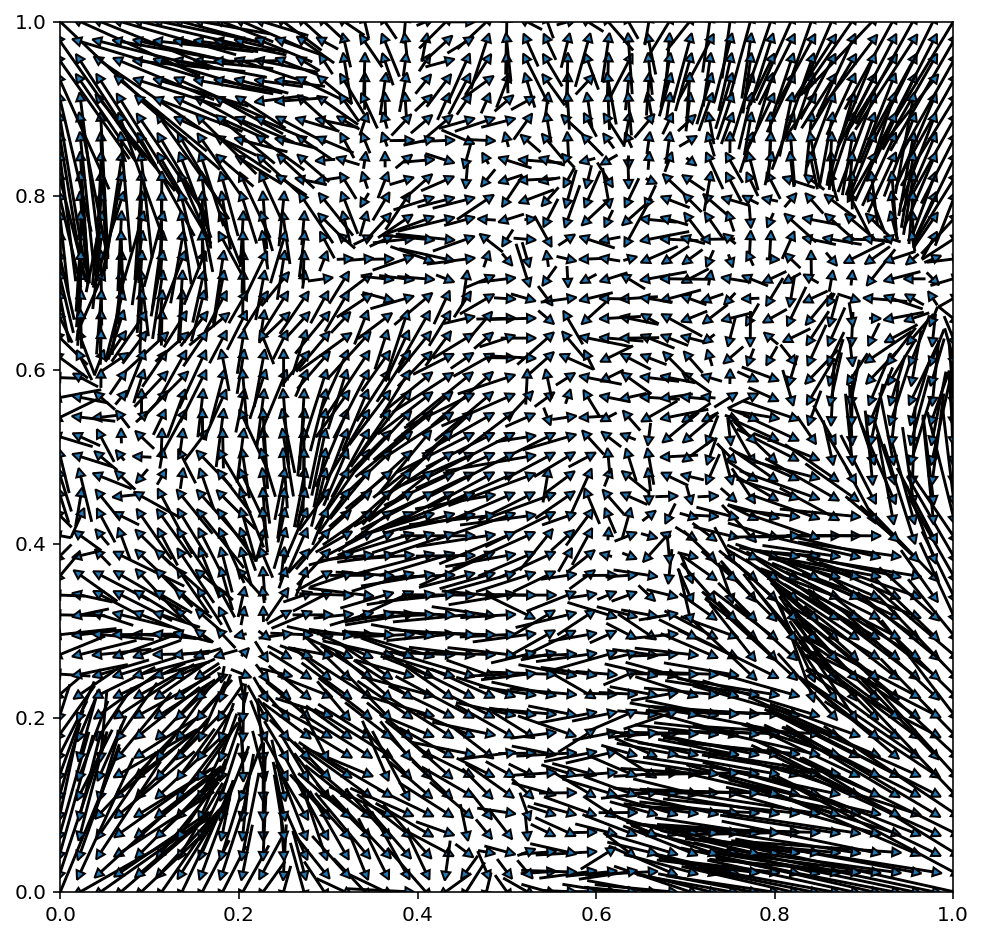

In [ ]:
help('hungarian')
%time row_assigns,col_assigns = hungarian.lap(np.copy(cost))
grid_hu = grid[col_assigns]
plt.figure(figsize=(8, 8))
for start, end in zip(data2d, grid_hu):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01)
plt.show()

Let's do it again but with the JV algorithm. The floating point version runs in under 4s, or around 1s if you cast to integers with `lap.lapjv(np.copy(cost).astype(int))`.

In [ ]:
help('lap')
%time min_cost, row_assigns, col_assigns = lap.lapjv(np.copy(cost))
grid_jv = grid[col_assigns]
print col_assigns.shape
plt.figure(figsize=(8, 8))
for start, end in zip(data2d, grid_jv):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_length=0.01, head_width=0.01)
plt.show()

Help on package lap:

NAME
    lap

FILE
    /Users/kyle/anaconda/lib/python2.7/site-packages/lap/__init__.py

DESCRIPTION
    LAP
    ``python-lap`` is a linear assignment problem solver using Jonker-Volgenant
    algorithm for dense (LAPJV) or sparse (LAPMOD) matrices.
    
    Functions
    ---------
    
    lapjv
        Find optimal (minimum-cost) assignment for a dense cost matrix.
    lapmod
        Find optimal (minimum-cost) assignment for a sparse cost matrix.

PACKAGE CONTENTS
    _lapjv
    lapmod
    tests (package)

FUNCTIONS
    lapjv(...)
        Solve linear assignment problem using Jonker-Volgenant algorithm.
        
        cost: (square) matrix containing the assignment costs
        extend_cost: whether or not extend a non-square matrix [default: False]
        cost_limit: an upper limit for a cost of a single assignment
                    [default: np.inf]
        return_cost: whether or not to return the assignment cost
        
        Returns (opt, x, y) whe

Finally, let's plot the results of both on top of each other to visually verify that the results are equivalent.

In [ ]:
plt.figure(figsize=(8, 8))
for start, end_hu, end_jv in zip(data2d, grid_hu, grid_jv):
    plt.arrow(start[0], start[1], end_hu[0] - start[0], end_hu[1] - start[1],
              head_length=0.01, head_width=0.01, color='red')
    plt.arrow(start[0], start[1], end_jv[0] - start[0], end_jv[1] - start[1],
              head_length=0.01, head_width=0.01, color='blue')
plt.show()